# 数理工学モデル化演習 第5回 課題
テキスト`20200526_textbook.ipynb`を読み、以下の演習を遂行せよ。

## 演習問題 
データ`students.csv`と`student_pair.csv`を利用し、次の数理モデルを実装せよ。

> - リスト  
> $S:生徒のリスト$  
> $C:クラスのリスト$  
> $S_{male}:男子生徒のリスト$  
> $S_{female}:女子生徒のリスト$  
> $S_{leader}:リーダー気質の生徒のリスト$  
> $S_{support}:特別な支援が必要な生徒のリスト$  
> $SS:特定ペアのリスト$
> - 変数  
> $x_{sc} \in \{0, 1\}\ \ (s \in S, c \in C)$  
> - 定数  
> $score_{s}\ \ (s \in S):生徒sの学力試験の結果$   
> $score\_mean:学力試験の学年平均点$   
> $init\_flag_{s,c}\ \ (s\in S, c\in C):初期クラス編成フラグ$
> - 制約式  
> $\sum_{c \in C} x_{s,c} = 1 \ \ (s \in S) $  
> $\sum_{s \in S} x_{s,c} \geq 39 \ \ (c \in C)$   
> $\sum_{s \in S} x_{s,c} \leq 40 \ \ (c \in C)$  
> $\sum_{s \in S_{male}} x_{s,c} \leq 20 \ \ (c \in C)$  
> $\sum_{s \in S_{female}} x_{s,c} \leq 20 \ \ (c \in C)$  
> $\sum_{s \in S_{leader}} x_{s,c} \geq 2 \ \ (c \in C)$  
> $\sum_{s \in S_{support}} x_{s,c} \leq 1 \ \ (c \in C)$  
> $\sum_{s \in S} score_{s} \cdot x_{sc} \leq  \ \ (c\in C)$  
> $score\_mean - 10 \leq \frac{\sum_{s \in S} score_{s} \cdot x_{sc}}{\sum_{s \in S} x_{sc}} \ \ (c\in C)$  
> $\frac{\sum_{s \in S} score_{s} \cdot x_{sc}}{\sum_{s \in S} x_{sc}} \leq score\_mean + 10 \ \ (c\in C)$   
> $x_{s1,c} + x_{s2,c} \leq 1\ \ (c \in C, (s1, s2) \in SS)$  
> 【目的関数】 初期クラス編成と最適化結果のクラス編成をできるだけ一致させる  
> maximize $\sum_{s \in S c \in C}x_{s,c}\cdot init\_flag_{s,c}$

次の行にコードを実装し、クラス名とそのクラスに割り当てられた生徒の学籍番号を表示すること。

In [2]:
import pandas
import pulp

s_dfm = pandas.read_csv('students.csv')
s_pair_dfm = pandas.read_csv('student_pairs.csv')

prob = pulp.LpProblem('ClassAssignmentProblem', pulp.LpMaximize)

# 生徒のリスト
S = s_dfm.student_id.tolist()

# クラスのリスト
C = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']

# 生徒とクラスのペアのリスト
SC = [(s,c) for s in S for c in C]

# 生徒をどのクラスに割り当てるを変数として定義
x = pulp.LpVariable.dicts('x', SC, cat='Binary')

# (1)各生徒は１つのクラスに割り当てる
for s in S:
    prob += pulp.lpSum([x[s,c] for c in C]) == 1

# (2)各クラスの生徒の人数は39人以上、40人以下とする。
for c in C:
    prob += pulp.lpSum([x[s,c] for s in S]) >= 39
    prob += pulp.lpSum([x[s,c] for s in S]) <= 40

# 男子生徒のリスト
S_male = [row.student_id for row in s_dfm.itertuples() if row.gender == 1]

# 女子生徒のリスト
S_female = [row.student_id for row in s_dfm.itertuples() if row.gender == 0]

# (3) 各クラスの男子生徒、女子生徒の人数は20人以下とする。
for c in C:
    prob += pulp.lpSum([x[s,c] for s in S_male]) <= 20
    prob += pulp.lpSum([x[s,c] for s in S_female]) <= 20

# 学力を辞書表現に変換
score = dict([(row.student_id, row.score) for row in s_dfm.itertuples()])

# 平均点の算出
score_mean = s_dfm.score.mean()

# (4) 各クラスの学力試験の平均点は学年平均点±10点とする。
for c in C:
    prob += pulp.lpSum([x[s,c]*score[s] for s in S]) >= (score_mean - 10) * pulp.lpSum([x[s,c] for s in S])
    prob += pulp.lpSum([x[s,c]*score[s] for s in S]) <= (score_mean + 10) * pulp.lpSum([x[s,c] for s in S])

# リーダー気質の生徒の集合
S_leader = [row.student_id for row in s_dfm.itertuples() if row.leader_flag == 1]

# (5)各クラスにリーダー気質の生徒を2人以上割り当てる。
for c in C:
    prob += pulp.lpSum([x[s,c] for s in S_leader]) >= 2

# 特別な支援が必要な生徒の集合
S_support = [row.student_id for row in s_dfm.itertuples() if row.support_flag == 1]

# (6) 特別な支援が必要な生徒は各クラスに1人以下とする。
for c in C:
    prob += pulp.lpSum([x[s,c] for s in S_support]) <= 1

    # 生徒の特定ペアリスト
SS = [(row.student_id1, row.student_id2) for row in s_pair_dfm.itertuples()]

# (7) 特定ペアの生徒は同一クラスに割り当てない。
for row in s_pair_dfm.itertuples():
    s1 = row.student_id1
    s2 = row.student_id2
    for c in C:
        prob += x[s1,c] + x[s2,c] <= 1

#ここから修正する        
        
        
# 初期クラス編成のデータを作成
# 学力をもとに順位を付与
s_dfm['score_rank'] = s_dfm.score.rank(ascending=False, method='first') 


# 学力順にクラス編成し、init_assigned_classカラムを作成
class_dic = {0:'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F', 6:'G', 7:'H'}
s_dfm['init_assigned_class'] = s_dfm.score_rank.map(lambda x:x % 8).map(class_dic)
s_dfm.head()        
        
    
# init_flagを作成
init_flag = dict([((s,c), 0)for s in S for c in C])
for row in s_dfm.itertuples():
    init_flag[row.student_id, row.init_assigned_class] = 1
    
    
# 目的関数:初期クラス編成と最適化結果のクラス編成をできるだけ一致させる
prob.objective = pulp.lpSum([x[s,c] * init_flag[s,c] for s,c in SC])        


# 求解
status = prob.solve()
print('Status:', pulp.LpStatus[status])

# 最適化結果の表示
# 各クラスに割り当てられている生徒のリストを辞書に格納
C2Ss = {}
for c in C:
    C2Ss[c] = [s for s in S if x[s,c].value()==1]

for c, Ss in C2Ss.items():
    print('Class:', c)
    print('Num:', len(Ss))
    print('Student:', Ss)
    print()

Status: Optimal
Class: A
Num: 40
Student: [2, 23, 56, 68, 76, 82, 89, 102, 106, 113, 115, 121, 123, 124, 127, 140, 172, 173, 185, 186, 204, 210, 228, 255, 267, 273, 274, 280, 285, 288, 289, 292, 295, 297, 304, 308, 311, 313, 316, 318]

Class: B
Num: 39
Student: [11, 14, 17, 30, 32, 35, 41, 49, 64, 66, 79, 83, 86, 88, 97, 114, 119, 122, 132, 134, 141, 149, 151, 165, 175, 178, 190, 198, 200, 209, 213, 216, 226, 237, 272, 296, 303, 306, 307]

Class: C
Num: 40
Student: [21, 38, 44, 46, 51, 54, 62, 63, 73, 75, 84, 85, 99, 120, 138, 142, 143, 144, 150, 166, 183, 184, 192, 193, 195, 201, 205, 207, 211, 212, 217, 221, 222, 243, 244, 263, 264, 287, 299, 315]

Class: D
Num: 40
Student: [5, 24, 39, 47, 50, 61, 67, 74, 90, 92, 93, 100, 109, 116, 131, 136, 147, 152, 155, 167, 169, 170, 176, 177, 196, 199, 214, 218, 219, 227, 230, 231, 236, 238, 239, 253, 257, 259, 271, 309]

Class: E
Num: 39
Student: [4, 8, 12, 13, 19, 22, 33, 43, 48, 55, 57, 59, 98, 112, 125, 130, 133, 137, 139, 153, 160, 189, 203

In [9]:
#一応確認
result_dfm2 = s_dfm.copy()

S2C = {}
for s in S:
    S2C[s] = [c for c in C if x[s,c].value()==1][0]
          
result_dfm2['assigned_class'] = result_dfm2.student_id.map(S2C)
result_dfm2.head(5)


,student_id,gender,leader_flag,support_flag,score,score_rank,init_assigned_class,assigned_class
0,1,0,0,0,335,109.0,F,F
1,2,1,0,0,379,38.0,G,A
2,3,0,0,0,350,79.0,H,H
3,4,0,0,0,301,172.0,E,E
4,5,1,0,0,317,147.0,D,D


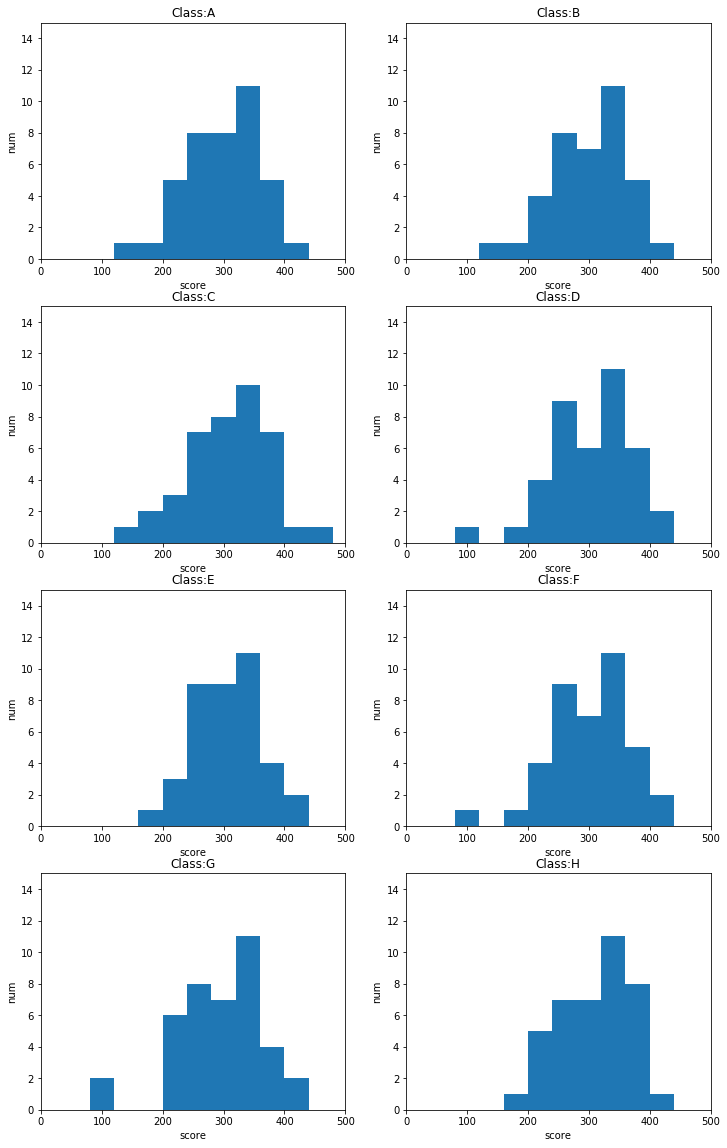

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,20))
for i, c in enumerate(C):
    cls_dfm = result_dfm2[result_dfm2.assigned_class==c]
    ax = fig.add_subplot(4, 2, i+1)
    ax.hist(cls_dfm.score, bins=range(0,500,40))
    ax.set_title('Class:{:s}'.format(c))
    ax.set_xlim(0, 500)
    ax.set_ylim(0,15)
    ax.set_xlabel('score')
    ax.set_ylabel('num')

## アンケート
以下に設問に回答してください。
1.
2. テキストを読むのにかかった時間をおしえてください。
3. 課題を遂行するのにかかった時間をおしえてください。

## 回答

1．
    
2．120分

3．30分

